In [1]:
import os
import shutil
import glob
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import splitfolders

import tensorflow as tf

tf.__version__

'2.5.0'

# Split data

In [2]:
should_prepare_data = True

In [3]:
def prepare_data():
    
    dirpaths = []
    class_names = []
    
    # generate list with roots for folders
    for dirpath, folder, _ in os.walk('./data/flowers/'):
        dirpaths.append(dirpath)
        class_names.append(folder)
    
    class_names = class_names[0]
        
    j = 0
    
    # loop through roots of image folders
    for dirpath in dirpaths[1:]:

        dst_dir = './data/input_flowers'

        if not os.path.exists(dst_dir):
            os.mkdir(dst_dir)

        i = 1  # no. of image

        for jpg_file in glob.iglob(os.path.join(dirpath, '*.jpg')):

            img_path = os.path.join(dst_dir, class_names[j])

            if not os.path.exists(img_path):
                os.mkdir(img_path)

            new_name = f'{class_names[j]}/{j}_{i}.jpg'

            shutil.copy(jpg_file, os.path.join(dst_dir, new_name))

            i += 1

        j += 1

    # split images to train/val/test folders
    splitfolders.ratio('./data/input_flowers', output='./data/output_flowers', seed=1337, ratio=(.7, .15, .15))
    
    return class_names

In [4]:
if should_prepare_data:
    prepare_data()

Copying files: 4317 files [00:00, 6990.73 files/s]


# Define train/val/test sets

In [39]:
batch_size = 32
img_height = 280
img_width = 280

data_dir = './data/output_flowers/train/'
val_dir = './data/output_flowers/val/'
test_dir = './data/output_flowers/test/'

In [40]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )



Found 3019 files belonging to 5 classes.


In [41]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 644 files belonging to 5 classes.


In [42]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 654 files belonging to 5 classes.


In [43]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

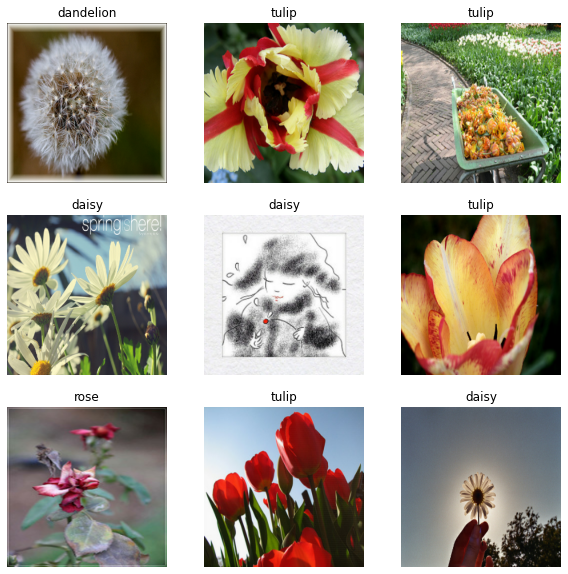

In [44]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Deep learning model

In [45]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [87]:
def get_model(num_classes):
    model = tf.keras.Sequential([

        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        layers.Dense(num_classes)  
    ])
    
    return model

model = get_model(5)
    
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_14 (Rescaling)     (None, 280, 280, 3)       0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 280, 280, 64)      1792      
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 140, 140, 64)      0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 140, 140, 64)      0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 140, 140, 64)      36928     
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 70, 70, 64)        0         
_________________________________________________________________
dropout_118 (Dropout)        (None, 70, 70, 64)      

In [88]:
epochs = 40

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/40
95/95 [==============================] - 12s 114ms/step - loss: 3.1636 - accuracy: 0.2362 - val_loss: 1.9266 - val_accuracy: 0.2438
Epoch 2/40
95/95 [==============================] - 11s 112ms/step - loss: 1.6418 - accuracy: 0.3445 - val_loss: 1.3471 - val_accuracy: 0.4394
Epoch 3/40
95/95 [==============================] - 11s 111ms/step - loss: 1.3367 - accuracy: 0.4833 - val_loss: 1.1996 - val_accuracy: 0.5466
Epoch 4/40
95/95 [==============================] - 11s 111ms/step - loss: 1.2474 - accuracy: 0.5025 - val_loss: 1.3821 - val_accuracy: 0.4565
Epoch 5/40
95/95 [==============================] - 11s 111ms/step - loss: 1.2006 - accuracy: 0.5432 - val_loss: 1.2449 - val_accuracy: 0.5280
Epoch 6/40
95/95 [==============================] - 11s 111ms/step - loss: 1.1972 - accuracy: 0.5631 - val_loss: 1.2877 - val_accuracy: 0.4798
Epoch 7/40
95/95 [==============================] - 11s 111ms/step - loss: 1.1050 - accuracy: 0.5985 - val_loss: 1.2536 - val_accuracy: 0.5264

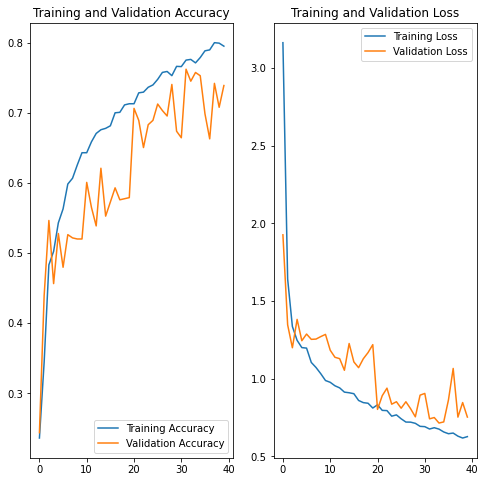

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [90]:
model.evaluate(test_ds)

21/21 [==============================] - 1s 30ms/step - loss: 0.7687 - accuracy: 0.7446


[0.7687488198280334, 0.7446483373641968]

## API model with skip connections

In [65]:
def conv2d_block(input_tensor, n_filters):
    
    x = input_tensor
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.MaxPooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    
    return x
    

In [95]:
def get_res_model(num_classes):
    
    inputs = layers.Input(shape=(img_height, img_width, 3))
    
    block_1 = conv2d_block(inputs, n_filters=64)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(block_1)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.add([block_1, x])
    
    block_2 = conv2d_block(x, n_filters=64)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(block_2)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.add([block_2, x])
    
    block_3 = conv2d_block(x, n_filters=128)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(block_3)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.add([block_3, x])
    
    block_4 = conv2d_block(x, n_filters=128)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(block_4)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.add([block_4, x])
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer='l2')(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer='l2')(x)
    outputs = layers.Dense(num_classes)(x)
    
    
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="res_model")
    
    return model

In [96]:
model_res = get_res_model(5)
model_res.summary()

Model: "res_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 280, 280, 3) 0                                            
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 280, 280, 64) 1792        input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_133 (MaxPooling2D (None, 140, 140, 64) 0           conv2d_200[0][0]                 
__________________________________________________________________________________________________
dropout_133 (Dropout)           (None, 140, 140, 64) 0           max_pooling2d_133[0][0]          
__________________________________________________________________________________________

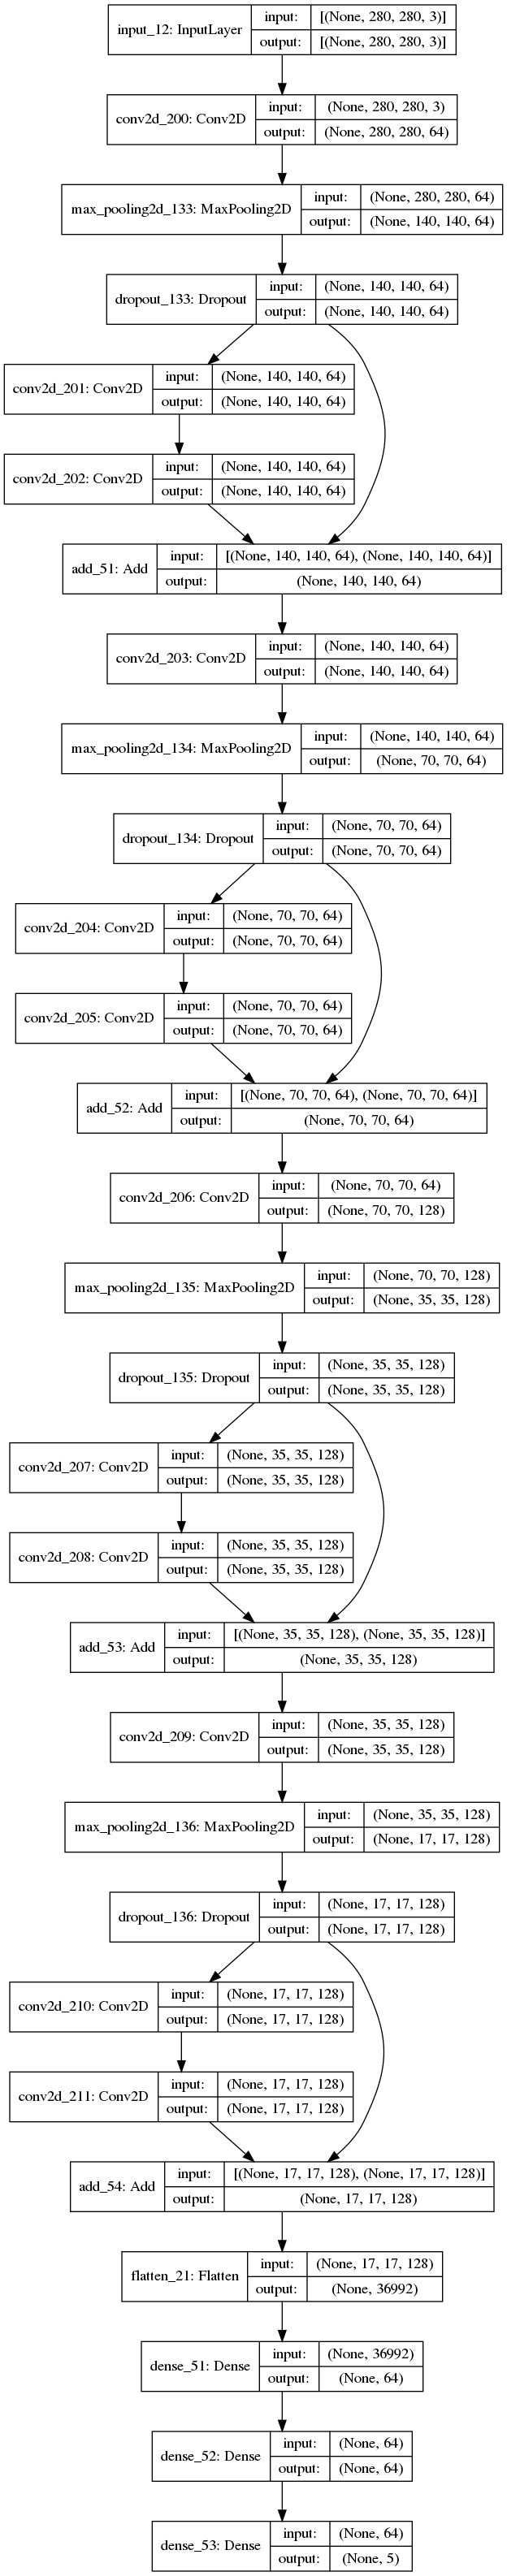

In [98]:
tf.keras.utils.plot_model(model_res, "res_model.png", show_shapes=True)


In [99]:
model_res.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [100]:
epochs = 40

history = model_res.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/40
95/95 [==============================] - 20s 197ms/step - loss: 338.2929 - accuracy: 0.2312 - val_loss: 3.1719 - val_accuracy: 0.2748
Epoch 2/40
95/95 [==============================] - 19s 196ms/step - loss: 3.2731 - accuracy: 0.2481 - val_loss: 2.0652 - val_accuracy: 0.2453
Epoch 3/40
95/95 [==============================] - 18s 194ms/step - loss: 2.1708 - accuracy: 0.2905 - val_loss: 1.8550 - val_accuracy: 0.3944
Epoch 4/40
95/95 [==============================] - 19s 196ms/step - loss: 1.6398 - accuracy: 0.3892 - val_loss: 1.6072 - val_accuracy: 0.3866
Epoch 5/40
95/95 [==============================] - 19s 197ms/step - loss: 1.4709 - accuracy: 0.4283 - val_loss: 1.3901 - val_accuracy: 0.4767
Epoch 6/40
95/95 [==============================] - 19s 197ms/step - loss: 1.4106 - accuracy: 0.4757 - val_loss: 1.4280 - val_accuracy: 0.4472
Epoch 7/40
95/95 [==============================] - 19s 196ms/step - loss: 1.3420 - accuracy: 0.4859 - val_loss: 1.4329 - val_accuracy: 0.42

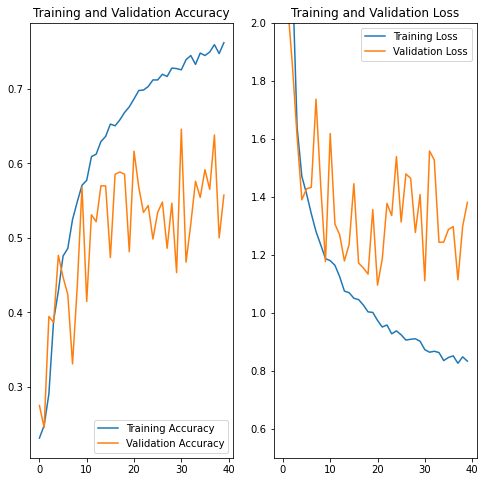

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim((0.5, 2))
plt.autoscale9
plt.show()